# 4.4.5 NLP Challenge using Romeo and Juliet

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import shakespeare, stopwords #,  qc

import spacy
from collections import Counter

import re
from sklearn.model_selection import train_test_split


### 1 . Data processing, cleaning, language parsing

First, taking a look at documents in shakespeare, and picking one.

In [2]:
print(shakespeare.fileids())

['a_and_c.xml', 'dream.xml', 'hamlet.xml', 'j_caesar.xml', 'macbeth.xml', 'merchant.xml', 'othello.xml', 'r_and_j.xml']


In [3]:
rj = shakespeare.raw('r_and_j.xml')
print(rj[:150])

<?xml version="1.0"?>
<?xml-stylesheet type="text/css" href="shakes.css"?>
<!-- <!DOCTYPE PLAY SYSTEM "play.dtd"> -->

<PLAY>
<TITLE>The Tragedy 


Originally I didn't know aout XML Element tree so I tried using a lot of regular expressions - a useful explanation of the specific regular expression used is [here](https://stackoverflow.com/questions/8784396/delete-the-words-between-two-delimiters-in-python) (for future reference).

However, then I found out about ElementTree, and learned a tiny bit about parsing with it. Here are some tutorials that I am still looking at: [this one from effbott](http://effbot.org/zone/element.htm), and [the python docs](https://docs.python.org/3.5/library/xml.etree.elementtree.html), [datacamp](https://www.datacamp.com/community/tutorials/python-xml-elementtree), [nltk](https://www.nltk.org/book/ch11.html).

In [4]:
import xml.etree.ElementTree as ET

tree = ET.parse('/Users/gemma/nltk_data/corpora/shakespeare/r_and_j.xml')
root = tree.getroot()

Taking a look at the categories of elements:

In [5]:
set([elem.tag for elem in root.iter()])

{'ACT',
 'FM',
 'GRPDESCR',
 'LINE',
 'P',
 'PERSONA',
 'PERSONAE',
 'PGROUP',
 'PLAY',
 'PLAYSUBT',
 'PROLOGUE',
 'SCENE',
 'SCNDESCR',
 'SPEAKER',
 'SPEECH',
 'STAGEDIR',
 'TITLE'}

Gaining an understanding of the structure of the document / tree:

In [6]:
parent_map = dict((c, p) for p in tree.getiterator() for c in p)

for key in parent_map:
    if key.text:
        print("key tag:  ", key.tag, " key text: ", key.text, " parent tag: ", parent_map[key].tag, " parent text: ", 
             parent_map[key].text)

key tag:   TITLE  key text:  The Tragedy of Romeo and Juliet  parent tag:  PLAY  parent text:  

key tag:   FM  key text:  
  parent tag:  PLAY  parent text:  

key tag:   PERSONAE  key text:  
  parent tag:  PLAY  parent text:  

key tag:   SCNDESCR  key text:  SCENE  Verona: Mantua.  parent tag:  PLAY  parent text:  

key tag:   PLAYSUBT  key text:  ROMEO AND JULIET  parent tag:  PLAY  parent text:  

key tag:   P  key text:  Text placed in the public domain by Moby Lexical Tools, 1992.  parent tag:  FM  parent text:  

key tag:   P  key text:  XML markup by Jon Bosak, 1996-1998.  parent tag:  FM  parent text:  

key tag:   P  key text:  XML Styling done by Ajay Juneja, 1999.  parent tag:  FM  parent text:  

key tag:   P  key text:  This work may be freely copied and distributed worldwide.  parent tag:  FM  parent text:  

key tag:   TITLE  key text:  Dramatis Personae  parent tag:  PERSONAE  parent text:  

key tag:   PERSONA  key text:  ESCALUS, prince of Verona.   parent tag:  PE

key tag:   LINE  key text:  A dog of the house of Montague moves me.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  GREGORY  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  To move is to stir; and to be valiant is to stand:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  therefore, if thou art moved, thou runn'st away.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  SAMPSON  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  A dog of that house shall move me to stand: I will  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  take the wall of any man or maid of Montague's.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  GREGORY  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  That shows thee a weak slave; for the weakest goes  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  to the wall.  parent tag:  SPEECH  parent text:  

key

key tag:   LINE  key text:  Canker'd with peace, to part your canker'd hate:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  If ever you disturb our streets again,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Your lives shall pay the forfeit of the peace.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  For this time, all the rest depart away:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  You Capulet; shall go along with me:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And, Montague, come you this afternoon,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  To know our further pleasure in this case,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  To old Free-town, our common judgment-place.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Once more, on pain of death, all men depart.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  


key tag:   LINE  key text:  The precious treasure of his eyesight lost:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Show me a mistress that is passing fair,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  What doth her beauty serve, but as a note  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Where I may read who pass'd that passing fair?  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Farewell: thou canst not teach me to forget.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  BENVOLIO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I'll pay that doctrine, or else die in debt.  parent tag:  SPEECH  parent text:  

key tag:   TITLE  key text:  SCENE II.  A street.  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Enter CAPULET, PARIS, and Servant  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:


key tag:   LINE  key text:  One fairer than my love! the all-seeing sun  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Ne'er saw her match since first the world begun.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  BENVOLIO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Tut, you saw her fair, none else being by,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Herself poised with herself in either eye:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  But in that crystal scales let there be weigh'd  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Your lady's love against some other maid  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  That I will show you shining at this feast,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And she shall scant show well that now shows best.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text: 

key tag:   SPEAKER  key text:  ROMEO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Nay, that's not so.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  MERCUTIO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I mean, sir, in delay  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  We waste our lights in vain, like lamps by day.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Take our good meaning, for our judgment sits  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Five times in that ere once in our five wits.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  ROMEO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And we mean well in going to this mask;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  But 'tis no wit to go.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  MERCUTIO  parent tag:  SPEECH  pare

key tag:   LINE  key text:  And quench the fire, the room is grown too hot.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Ah, sirrah, this unlook'd-for sport comes well.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Nay, sit, nay, sit, good cousin Capulet;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  For you and I are past our dancing days:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  How long is't now since last yourself and I  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Were in a mask?  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  Second Capulet  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  By'r lady, thirty years.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  CAPULET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  What, man! 'tis not so much, 'tis not so much:  parent tag:  SPEECH  parent text:  

k

key tag:   SPEAKER  key text:  Chorus  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Now old desire doth in his death-bed lie,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And young affection gapes to be his heir;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  That fair for which love groan'd for and would die,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  With tender Juliet match'd, is now not fair.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Now Romeo is beloved and loves again,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Alike betwitched by the charm of looks,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  But to his foe supposed he must complain,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And she steal love's sweet bait from fearful hooks:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Being held a fo

key tag:   LINE  key text:  'Tis but thy name that is my enemy;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Thou art thyself, though not a Montague.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  What's Montague? it is nor hand, nor foot,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Nor arm, nor face, nor any other part  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Belonging to a man. O, be some other name!  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  What's in a name? that which we call a rose  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  By any other name would smell as sweet;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  So Romeo would, were he not Romeo call'd,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Retain that dear perfection which he owes  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Without t

key tag:   LINE  key text:  Let me stand here till thou remember it.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  JULIET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I shall forget, to have thee still stand there,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Remembering how I love thy company.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  ROMEO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And I'll still stay, to have thee still forget,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Forgetting any other home but this.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  JULIET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  'Tis almost morning; I would have thee gone:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And yet no further than a wanton's bird;  parent tag:  SPEECH  parent text:  

key tag:   LINE 

  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key 

key tag:   SPEAKER  key text:  MERCUTIO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Thy wit is a very bitter sweeting; it is a most  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  sharp sauce.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  ROMEO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And is it not well served in to a sweet goose?  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  MERCUTIO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  O here's a wit of cheveril, that stretches from an  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  inch narrow to an ell broad!  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  ROMEO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I stretch it out for that word 'broad;' which added  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  to the goose, proves thee far 

key tag:   LINE  key text:  Peter!  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  PETER  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Anon!  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  Nurse  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Peter, take my fan, and go before and apace.  parent tag:  SPEECH  parent text:  

key tag:   TITLE  key text:  SCENE V.  Capulet's orchard.  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Enter JULIET  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Exit PETER  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent 

key tag:   TITLE  key text:  ACT III  parent tag:  ACT  parent text:  None
key tag:   TITLE  key text:  SCENE I.  A public place.  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Enter MERCUTIO, BENVOLIO, Page, and Servants  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:

key tag:   SPEAKER  key text:  MERCUTIO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Come, sir, your passado.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  ROMEO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Draw, Benvolio; beat down their weapons.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Gentlemen, for shame, forbear this outrage!  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Tybalt, Mercutio, the prince expressly hath  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Forbidden bandying in Verona streets:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Hold, Tybalt! good Mercutio!  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  MERCUTIO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I am hurt.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  A plague o' both your houses! I am sped.  paren

key tag:   LINE  key text:  Leap to these arms, untalk'd of and unseen.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Lovers can see to do their amorous rites  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  By their own beauties; or, if love be blind,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  It best agrees with night. Come, civil night,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Thou sober-suited matron, all in black,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And learn me how to lose a winning match,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Play'd for a pair of stainless maidenhoods:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Hood my unmann'd blood, bating in my cheeks,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  With thy black mantle; till strange love, grown bold,  parent tag:  SPEECH  parent text:  

key t

key tag:   STAGEDIR  key text:  Knocking  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Enter Nurse  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Drawing his

key tag:   LINE  key text:  Thy noble shape is but a form of wax,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Digressing from the valour of a man;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Thy dear love sworn but hollow perjury,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Killing that love which thou hast vow'd to cherish;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Thy wit, that ornament to shape and love,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Misshapen in the conduct of them both,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Like powder in a skitless soldier's flask,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Is set afire by thine own ignorance,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  And thou dismember'd with thine own defence.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  What,

  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Exit  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Exit  parent tag:  SCENE  parent text:  None
key tag:   SPEAKER  key text:  JULIET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Wilt thou be gone? it is not yet near day:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  It was the nightingale, and not the lark,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  That pierced the fearful hollow of thine ear;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Nightly she sings on yon pomegranate-tree:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Believe me, love, it was the nightingale.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  ROMEO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  It was t

key tag:   SPEAKER  key text:  LADY CAPULET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Ay, sir; but she will none, she gives you thanks.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I would the fool were married to her grave!  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  CAPULET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Soft! take me with you, take me with you, wife.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  How! will she none? doth she not give us thanks?  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Is she not proud? doth she not count her blest,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Unworthy as she is, that we have wrought  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  So worthy a gentleman to be her bridegroom?  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  JULIET  parent tag:  SPE

key tag:   SPEAKER  key text:  JULIET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  What must be shall be.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  FRIAR LAURENCE  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  That's a certain text.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  PARIS  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Come you to make confession to this father?  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  JULIET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  To answer that, I should confess to you.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  PARIS  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Do not deny to him that you love me.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  JULIET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I will confe

key tag:   LINE  key text:  Go, be gone.  parent tag:  SPEECH  parent text:  

key tag:   STAGEDIR  key text:  Exit Second Servant  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  We shall be much unfurnished for this time.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  What, is my daughter gone to Friar Laurence?  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  Nurse  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Ay, forsooth.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  CAPULET  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Well, he may chance to do some good on her:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  A peevish self-will'd harlotry it is.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  Nurse  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  See where she comes from shrift with merry look.  parent tag:

key tag:   STAGEDIR  key text:  Re-enter Nurse  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Go waken Juliet, go and trim her up;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I'll go and chat with Paris: hie, make haste,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Make haste; the bridegroom he is come already:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Make haste, I say.  parent tag:  SPEECH  parent text:  

key tag:   TITLE  key text:  SCENE V.  Juliet's chamber.  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Enter Nurse  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Enter LADY CAPULET  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   SPE

key tag:   LINE  key text:  Honest goodfellows, ah, put up, put up;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  For, well you know, this is a pitiful case.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  First Musician  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Ay, by my troth, the case may be amended.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  PETER  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Musicians, O, musicians, 'Heart's ease, Heart's  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  ease:' O, an you will have me live, play 'Heart's ease.'  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  First Musician  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Why 'Heart's ease?'  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  PETER  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  O, musi

key tag:   LINE  key text:  Doing more murders in this loathsome world,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Than these poor compounds that thou mayst not sell.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I sell thee poison; thou hast sold me none.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Farewell: buy food, and get thyself in flesh.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Come, cordial and not poison, go with me  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  To Juliet's grave; for there must I use thee.  parent tag:  SPEECH  parent text:  

key tag:   TITLE  key text:  SCENE II.  Friar Laurence's cell.  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Enter FRIAR JOHN  parent tag:  SCENE  parent text:  None
key tag:   SPEECH  key text:  
  parent tag:  SCENE  parent text:  None
key tag:   STAGEDIR  key text:  Enter FRIAR LAURENCE  parent tag:  

key tag:   SPEAKER  key text:  BALTHASAR  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  I will be gone, sir, and not trouble you.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  ROMEO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  So shalt thou show me friendship. Take thou that:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Live, and be prosperous: and farewell, good fellow.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  BALTHASAR  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  His looks I fear, and his intents I doubt.  parent tag:  SPEECH  parent text:  

key tag:   STAGEDIR  key text:  Aside  parent tag:  LINE  parent text:  None
key tag:   SPEAKER  key text:  ROMEO  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Thou detestable maw, thou womb of death,  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Gorged with the dearest morse

key tag:   LINE  key text:  Who here hath lain these two days buried.  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Go, tell the prince: run to the Capulets:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Raise up the Montagues: some others search:  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  We see the ground whereon these woes do lie;  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  But the true ground of all these piteous woes  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  We cannot without circumstance descry.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  Second Watchman  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Here's Romeo's man; we found him in the churchyard.  parent tag:  SPEECH  parent text:  

key tag:   SPEAKER  key text:  First Watchman  parent tag:  SPEECH  parent text:  

key tag:   LINE  key text:  Hold him in safety, till the pr

Next we will extract the elements of interest and put them in a dataframe.

At the same time, I'll clean up the lines using the below function, as we go, for the sake of efficiency.

In [7]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [8]:
# trying to get all of the speakers and their lines in an array

rows = {}

l = 0 

for i, act in enumerate(root.findall('ACT')):
    for s, act_t in enumerate(act.findall('TITLE')):
        print(act_t.text)
    for j, scene in enumerate(act.findall('SCENE')):
        for q, scene_t in enumerate(scene.findall('TITLE')):
            print(scene_t.text)
            only_number = scene_t.text.split('.',1)
        for k, speech in enumerate(scene.findall('SPEECH')):
            for i, speaker in enumerate(speech.findall('SPEAKER')):
                
                # there is an instance of LADY  CAPULET which shouldbe LADY CAPULET
                if speaker.text == 'LADY  CAPULET':
                    speaker.text = speaker.text.replace('LADY  CAPULET', 'LADY CAPULET')
                
                all_lines = []
                for line in speech.findall('LINE'):
                    if line.text:
                        line.text = text_cleaner(line.text)
                        all_lines.append(line.text)
                
                rows[l] = ([act_t.text, only_number[0], only_number[1], speaker.text, ' '.join(all_lines)])
                l+=1


ACT I
SCENE I.  Verona. A public place.
SCENE II.  A street.
SCENE III.  A room in Capulet's house.
SCENE IV.  A street.
SCENE V.  A hall in Capulet's house.
ACT II
SCENE I.  A lane by the wall of Capulet's orchard.
SCENE II.  Capulet's orchard.
SCENE III.  Friar Laurence's cell.
SCENE IV.  A street.
SCENE V.  Capulet's orchard.
SCENE VI.  Friar Laurence's cell.
ACT III
SCENE I.  A public place.
SCENE II.  Capulet's orchard.
SCENE III.  Friar Laurence's cell.
SCENE IV.  A room in Capulet's house.
SCENE V.  Capulet's orchard.
ACT IV
SCENE I.  Friar Laurence's cell.
SCENE II.  Hall in Capulet's house.
SCENE III.  Juliet's chamber.
SCENE IV.  Hall in Capulet's house.
SCENE V.  Juliet's chamber.
ACT V
SCENE I.  Mantua. A street.
SCENE II.  Friar Laurence's cell.
SCENE III.  A churchyard; in it a tomb belonging to the Capulets.


In [9]:
df = pd.DataFrame.from_dict(data=rows, orient='index', columns=['Act', 'Scene', 'Scene_Name','Speaker', 'Line'])

df.head()

,Act,Scene,Scene_Name,Speaker,Line
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals."
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers."
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw."
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ..."
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved."


Next, let's parse the lines in a new column with spacy.

In [10]:
# first let me make sure this will work

nlp = spacy.load('en_core_web_lg')

testing = nlp(df.loc[1, 'Line'])

for token in testing:
    print(token.lemma_)

no
,
for
then
-PRON-
should
be
collier
.


In [11]:
# it worked! let's apply it to the whole dataframe of lines

df['parsed'] = df['Line'].apply(nlp)

In [12]:
df.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ..."
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)"
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l..."
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,..."
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)"


In [13]:
# double checking that LADY  CAPULET was replaced w correctly spaced name
df[df['Speaker'] == 'LADY  CAPULET']

,Act,Scene,Scene_Name,Speaker,Line,parsed


### 2. Creating features using two different NLP methods, BOW and tf-idf

**a. BOW**

In order to get a list of the common words from the text, first I'm going to put all the lines together into one text (one string) and then run spaCy on the resulting text. This is a little redundant since I already ran spaCy on each individual line, but it is the best way I could think of to keep the lines organized by speaker in the dataframe.

In [14]:
all_the_lines = []

# just look at "LINE"s in the tree
for line in root.iter('LINE'):
    # make sure it's a string (ignore the "None" entries)
    if isinstance(line.text, str):
        all_the_lines.append(line.text)
    
complete_doc = nlp((' '.join(all_the_lines)))

Then I'll use the bag of words function to get the most common words across all of the lines.

In [15]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]

In [16]:
common_words = bag_of_words(complete_doc)

Add the common words as word counts in the dataframe:

In [17]:
def bow_features(original_df, common_words):
    
    # copy the dataframe so your bow features will be in a new one and wont affect the original data
    df = original_df.copy(deep=True)
    
    # Add the words to the dataframe and set all counts to 0
    for word in common_words:
        df[word] = 0
        
    # Process each row, counting the occurrence of words in each parsed sentence.
    for i, sentence in enumerate(df['parsed']):
        
        # I already converted the sentence to lemmas, and filtered out punctuation and stop words.
        # Now I'm just going to get a list of the words in each line that are in the common words list.
        words = [token.lemma_
                 for token in sentence
                 if token.lemma_ in common_words
                ]
        
        # Populate the row with word counts
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [18]:
df_plus_bow = bow_features(df,common_words)

Processing row 0
Processing row 500


In [19]:
df_plus_bow.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed,-PRON-,be,and,the,...,hatred,intercession,stead,plain,homely,plainly,woo'd,forsake,maria,brine
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ...",2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)",1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l...",3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,...",2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)",1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


We will use the bow features in a model soon, but first I'll create the features using df-idf.

**b. df-idf**

Let's take a look at the dataframe again.

In [20]:
df.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ..."
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)"
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l..."
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,..."
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)"


It looks ready to run the model, so let's go to the next step.

### 3. Supervised learning models

Using the different sets of features from above. First let's use bow with random forest and see if we can predict the speaker.

a. **BOW** 

<em>i. with Random Forest</em>

In [21]:
from sklearn import ensemble

In [22]:
rfc = ensemble.RandomForestClassifier()
Y = df_plus_bow['Speaker']
X = df_plus_bow.drop(['Act','Scene', 'Scene_Name','Speaker', 'Line', 'parsed'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9840954274353877

Test set score: 0.17261904761904762


In [23]:
from sklearn.model_selection import cross_val_score

validate = cross_val_score(rfc, X_test, y_test, cv=10)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


The warning shows a problem with the number of members in each class, meaning in this case the number of lines for some of the speakers. Let's see if we can drop speakers with less than a certain threshold of lines.

In [24]:

# get the counts of each speaker and add it as a column
df_plus_bow['Speaker_counts'] = df_plus_bow.groupby('Speaker')['Line'].transform('count')

# drop lines whose speakers have less than 10 lines from the rows
df_plus_bow_max = df_plus_bow.drop(df_plus_bow[df_plus_bow.Speaker_counts < 10].index)

In [25]:
# double check it worked 
df_plus_bow_max.groupby('Speaker')['Speaker_counts'].count().sort_values(ascending=False)

Speaker
ROMEO             163
JULIET            118
Nurse              89
BENVOLIO           64
MERCUTIO           62
FRIAR LAURENCE     55
CAPULET            50
LADY CAPULET       45
PARIS              23
SAMPSON            20
TYBALT             17
PRINCE             16
GREGORY            15
PETER              13
BALTHASAR          12
Servant            10
MONTAGUE           10
Name: Speaker_counts, dtype: int64

In [26]:
# re run rfc

rfc = ensemble.RandomForestClassifier()
Y_max = df_plus_bow_max['Speaker']
X_max = df_plus_bow_max.drop(['Act','Scene', 'Scene_Name','Speaker', 'Line', 'parsed', 'Speaker_counts'], 1)

X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max, 
                                                    Y_max,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train_max, y_train_max)

print('Training set score:', rfc.score(X_train_max, y_train_max))
print('\nTest set score:', rfc.score(X_test_max, y_test_max))

Training set score: 0.9850746268656716

Test set score: 0.19169329073482427


In [27]:
validate = cross_val_score(rfc, X_train_max, y_train_max, cv=5)

In [28]:
print(validate)
print(np.mean(validate), '+/-', np.std(validate)*2)

[0.2038835  0.17708333 0.15957447 0.15909091 0.18181818]
0.17629007749463232 +/- 0.033079406060104434


In [29]:
print("Accuracy: %0.2f (+/- %0.2f)" % (validate.mean(), validate.std() * 2))

Accuracy: 0.18 (+/- 0.03)


<em>ii. with Logistic Regression</em>

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(503, 2000) (503,)
Training set score: 0.9502982107355865

Test set score: 0.23809523809523808


In [32]:
validate_lr = cross_val_score(lr, X_train_max, y_train_max, cv=5)

In [33]:
print("Accuracy: %0.2f (+/- %0.2f)" % (validate_lr.mean(), validate_lr.std() * 2))

Accuracy: 0.27 (+/- 0.04)


<em>iii. with Gradient Boosting</em>

In [34]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.9701789264413518

Test set score: 0.24404761904761904


In [35]:
validate_gb = cross_val_score(clf,X_train_max,y_train_max,cv=5)

In [36]:
print("Accuracy: %0.2f (+/- %0.2f)" % (validate_gb.mean(), validate_gb.std() * 2))

Accuracy: 0.23 (+/- 0.03)


**b. tf-idf**

Next we'll run the tf-idf vectorizer to get the vectors for each line. Normally this is on a paragraph basis but since this is a play lines should be a good substitute.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(df['Line'], test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.75, # drop words that occur in more than 75 percent of the paragraphs
                             min_df=3, # only use words that appear at least 3 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
lines_tfidf=vectorizer.fit_transform(df['Line'])
print("Number of features: %d" % lines_tfidf.get_shape()[1])

# inititally tried model with parameters: max_df 0.75, min_df 10, # of features was 187

Number of features: 796


In [38]:

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(lines_tfidf, test_size=0.4, random_state=0)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was
# present once in that sentence.
print('Original sentence:', X_train[0])
print('Tf_idf vector:', tfidf_bypara[0])

Original sentence: Gregory, o' my word, we'll not carry coals.
Tf_idf vector: {'laurence': 0.41324507177540226, 'friar': 0.336058721652412, 'gone': 0.6486787186462298, 'daughter': 0.3673003861933039, 'time': 0.31424202170388116, 'shall': 0.2486993050410113}


<em>Dimension reduction</em>

In [39]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space.
svd= TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 98.96534125594387
Component 0:
Line
Thou know'st the mask of night is on my face, Else would a maiden blush bepaint my cheek For that which thou hast heard me speak to-night Fain would I dwell on form, fain, fain deny What I have spoke: but farewell compliment! Dost thou love me? I know thou wilt say 'Ay,' And I will take thy word: yet if thou swear'st, Thou mayst prove false; at lovers' perjuries Then say, Jove laughs. O gentle Romeo, If thou dost love, pronounce it faithfully: Or if thou think'st I am too quickly won, I'll frown and be perverse an say thee nay, So thou wilt woo; but else, not for the world. In truth, fair Montague, I am too fond, And therefore thou mayst think my 'havior light: But trust me, gentleman, I'll prove more true Than those that have more cunning to be strange. I should have been more strange, I must confess, But that thou overheard'st, ere I was ware, My true love's passion: therefore pardon me, And not impute t

<em>Sentence similarity with latent semantic analysis</em>

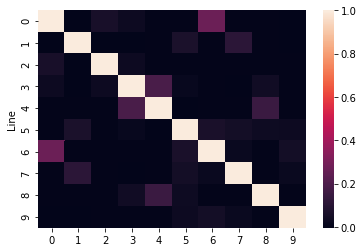

Key:
0 Go, be gone. We shall be much unfurnished for this time. What, is my daughter gone to Friar Laurence?
1 Give me the letter; I will look on it. Where is the county's page, that raised the watch? Sirrah, what made your master in this place?
2 Patience perforce with wilful choler meeting Makes my flesh tremble in their different greeting. I will withdraw: but this intrusion shall Now seeming sweet convert to bitter gall.
3 No, 'tis not so deep as a well, nor so wide as a church-door; but 'tis enough,'twill serve: ask for me to-morrow, and you shall find me a grave man. I am peppered, I warrant, for this world. A plague o' both your houses! 'Zounds, a dog, a rat, a mouse, a cat, to scratch a man to death! a braggart, a rogue, a villain, that fights by the book of arithmetic! Why the devil came you between us? I was hurt under your arm.
4 'Tis more, 'tis more, his son is elder, sir; His son is thirty.
5 I hear some noise. Lady, come from that nest Of death, contagion, and unnatural s

In [40]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


### 4. Assess your models using cross-validation and determine whether one model performed better.



In [41]:
order = ['random forest', 'logistic regression', 'gradient boosting']

models = pd.DataFrame(index=order)

models['training'] = [0.9880715705765407, 0.9463220675944334, 0.9681908548707754]
models['testing'] = [0.16071428571428573,0.23809523809523808, 0.22916666666666666]
models['cross_val_acc'] = ['0.16 (+/- 0.13)','0.27 (+/- 0.04)','0.23 (+/- 0.03)']

models

,training,testing,cross_val_acc
random forest,0.988072,0.160714,0.16 (+/- 0.13)
logistic regression,0.946322,0.238095,0.27 (+/- 0.04)
gradient boosting,0.968191,0.229167,0.22 (+/- 0.03)


It looks like logistic regression scored better in testing and the cross validation, though gradient boosting and random forest were both better then it on the training set - which sounds a lot like overfitting. Therefore the model that performed the best on the BOW features was the **logistic regression**.

### 5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

Let's try to improve the logistic regression model with the BOW features, since that one performed the best. First, let's take another look at the data.

In [42]:
df_plus_bow.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed,-PRON-,be,and,the,...,intercession,stead,plain,homely,plainly,woo'd,forsake,maria,brine,Speaker_counts
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ...",2,0,0,0,...,0,0,0,0,0,0,0,0,0,20
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)",1,1,0,0,...,0,0,0,0,0,0,0,0,0,15
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l...",3,1,0,0,...,0,0,0,0,0,0,0,0,0,20
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,...",2,0,0,1,...,0,0,0,0,0,0,0,0,0,15
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)",1,1,0,0,...,0,0,0,0,0,0,0,0,0,20


### <em>feature engineering</em>

For features, we'll use Act and Scene. I'll add some more features too - first, word count.

In [43]:
df_plus_bow['word_count'] = len(df['parsed'])

Let's also add a count of the unique parts of speech in each sentence.

In [44]:
def unique_pos(Series):
    
    allpos = [token.pos_ for token in Series]
        
    return (len(set(allpos)))

In [67]:
df_plus_bow['unique_pos'] = df_plus_bow['parsed'].apply(unique_pos)

Let's try and use word vectors on the sentence level.

In [46]:
# First I'm double checking that all of the words in the doc have vectors already.

count = 0
for token in complete_doc:
    if token.has_vector:
        count+=1
    
print(len(complete_doc), count)


30085 29678


In [68]:
import re 

# couldnt search complete_doc so rejoined the lines to search through w/ regular expression
okay_again = ' '.join(all_the_lines)


def get_vector(value):
    
    # get the location of the sentence in the nlp loaded text

    target = re.compile(value)
    
    # find the target in complete_doc and return it as an itme
    found = target.search(okay_again)
    
    if found != None:
    
        # beginning and end
        start = found.start()
        end = found.end()
    
        span = complete_doc[start:end]
        
        if span.has_vector:
            return span.vector_norm
        else:
            return 0
    else:
        return 0

df_plus_bow['vector'] = df_plus_bow['Line'].apply(get_vector)

In [69]:
df_plus_bow.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed,-PRON-,be,and,the,...,homely,plainly,woo'd,forsake,maria,brine,Speaker_counts,word_count,unique_pos,vector
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ...",2,0,0,0,...,0,0,0,0,0,0,20,839,8,3.022147
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)",1,1,0,0,...,0,0,0,0,0,0,15,839,7,3.289926
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l...",3,1,0,0,...,0,0,0,0,0,0,20,839,6,3.212513
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,...",2,0,0,1,...,0,0,0,0,0,0,15,839,9,3.014298
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)",1,1,0,0,...,0,0,0,0,0,0,20,839,4,3.084016


In [77]:
# convert act and scene to numbers

def get_numeric(name):
    
    roman = {'IV' : 4, 'V': 5, 'VI' : 6, 'VII' : 7}
    
    pieces = name.split()
    if 'V' not in pieces[1]:
        return len(pieces[1])
    else:
        return roman[pieces[1]]

df['Act_num'] = df['Act'].apply(get_numeric)
df['Scene_num'] = df['Scene'].apply(get_numeric)

### <em>fitting the logistic model</em>
    

In [78]:
# 1. getting the testing and training samples

Y_new_f = df_plus_bow_max['Speaker']
X_new_f = df_plus_bow_max.drop(['Act','Scene', 'Scene_Name', 'Speaker', 'Line', 'parsed'], 1)

X_train_new_f, X_test_new_f, y_train_new_f, y_test_new_f = train_test_split(X_new_f, 
                                                    Y_new_f,
                                                    test_size=0.4,
                                                    random_state=0)

In [79]:
lr = LogisticRegression()
lr.fit(X_train_new_f, y_train_new_f)
print(X_train_new_f.shape, y_train_new_f.shape)
print('Training set score:', lr.score(X_train_new_f, y_train_new_f))
print('\nTest set score:', lr.score(X_test_new_f, y_test_new_f))

(469, 2001) (469,)
Training set score: 0.9744136460554371

Test set score: 0.4249201277955272


In [80]:
validate_lr2 = cross_val_score(lr, X_train_new_f, y_train_new_f, cv=5)


In [81]:
print("Accuracy: %0.2f (+/- %0.2f)" % (validate_lr2.mean(), validate_lr2.std() * 2))

Accuracy: 0.45 (+/- 0.07)
